In [1]:
!pip install transformers

  Using cached transformers-4.56.1-py3-none-any.whl.metadata (42 kB)
  Using cached huggingface_hub-0.34.4-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.22.0-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.6.2-cp38-abi3-win_amd64.whl.metadata (4.1 kB)
Using cached transformers-4.56.1-py3-none-any.whl (11.6 MB)
Using cached huggingface_hub-0.34.4-py3-none-any.whl (561 kB)
Using cached tokenizers-0.22.0-cp39-abi3-win_amd64.whl (2.7 MB)
Using cached safetensors-0.6.2-cp38-abi3-win_amd64.whl (320 kB)

   ---------- ----------------------------- 1/4 [huggingface-hub]
   ---------- ----------------------------- 1/4 [huggingface-hub]
   ------------------------------ --------- 3/4 [transformers]
   ------------------------------ --------- 3/4 [transformers]
   ------------------------------ --------- 3/4 [transformers]
   ------------------------------ --------- 3/4 [transformers]
   ------------------------------ --------- 3/4 [transformers]
   --------

In [2]:
from transformers import AutoImageProcessor, TFViTForImageClassification

In [3]:
import tensorflow as tf
from tensorflow import keras
#from transformers import AutoImageProcessor, TFViTForImageClassification
import tensorflow as tf
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [4]:

model = TFViTForImageClassification.from_pretrained(
        'facebook/dino-vitb16',
        num_labels=1,
        ignore_mismatched_sizes=True
    )
model.vit.trainable = False  # Congelar capas base
# model.classifier = tf.keras.layers.Dense(1, activation="sigmoid")


model.summary()


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at facebook/dino-vitb16 were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/kernel:0', 'vit/pooler/dense/bias:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier']
You should

Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 85799425 (327.30 MB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 85798656 (327.30 MB)
_________________________________________________________________


In [8]:
base_dir = "C:/Users/basti/OneDrive/Escritorio/datos/dataset1/train"


datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)


train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode="binary",
    subset="training",
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode="binary",
    subset="validation"
)


Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [9]:
print("Clases encontradas:", train_generator.class_indices)
print("Total imágenes entrenamiento:", train_generator.samples)
print("Total imágenes validación:", val_generator.samples)


Clases encontradas: {'fake': 0, 'real': 1}
Total imágenes entrenamiento: 160
Total imágenes validación: 40


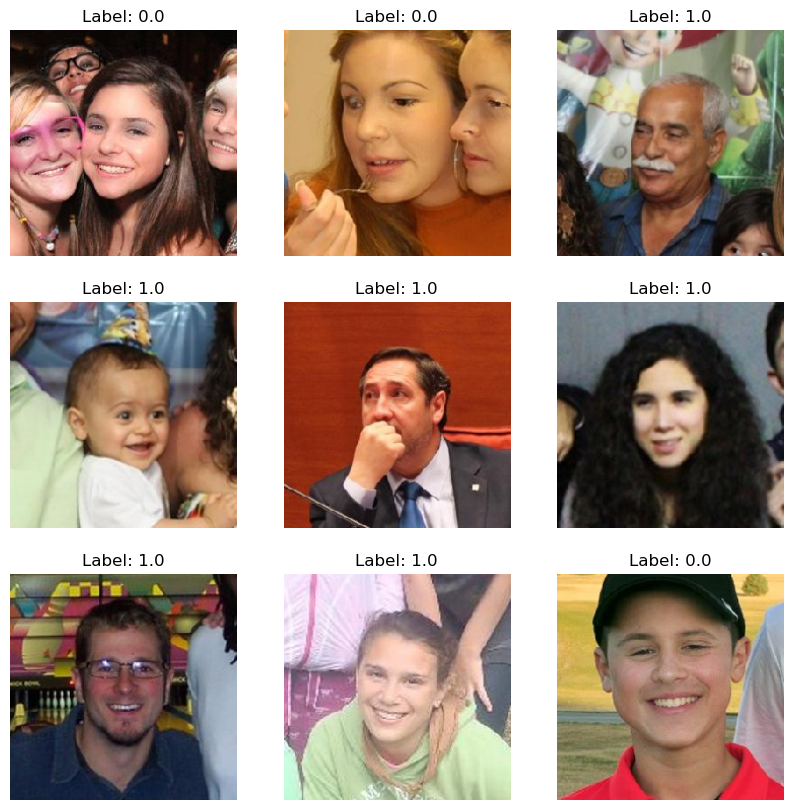

In [10]:
from PIL import Image

# Obtener un lote de imágenes
x_batch, y_batch = next(train_generator)

# Visualizar un par de imágenes del lote
plt.figure(figsize=(10, 10))

for i in range(9):  # Mostrar 9 imágenes
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])  # Mostrar la imagen
    plt.title(f'Label: {y_batch[i]}')  # Etiqueta correspondiente (0 o 1)
    plt.axis('off')

plt.show()


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
from transformers import AutoImageProcessor
import numpy as np


image_processor = AutoImageProcessor.from_pretrained('facebook/dino-vitb16', do_rescale=False)


def preprocess_batch(batch):
    images, labels = batch
    pixel_values = image_processor(images=images, return_tensors="tf").pixel_values
    return pixel_values, labels

train_data = map(preprocess_batch, train_generator)
val_data = map(preprocess_batch, val_generator)


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
pip install --upgrade numpy tensorflow


In [13]:
#opt = Adam(learning_rate=1e-3)
model.compile(
optimizer='adam',
loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
metrics=["accuracy"]
)

In [14]:
for batch, labels in train_generator:
    print("Shape del batch de imágenes:", batch.shape)  # Debería ser (batch_size, 224, 224, 3)
    print("Shape de las etiquetas:", labels.shape)      # Debería ser (batch_size,)
    break


Shape del batch de imágenes: (32, 224, 224, 3)
Shape de las etiquetas: (32,)


In [16]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

In [15]:
from transformers import Trainer, TrainingArguments
#import tensorflow as tf

# Verificar si TensorFlow detecta la GPU
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    # Configurar TensorFlow para usar la primera GPU disponible
    tf.config.set_visible_devices(gpus[0], 'GPU')
    print("GPU está siendo utilizada para entrenamiento.")
else:
    print("No se detectó GPU, utilizando CPU.")


No se detectó GPU, utilizando CPU.


In [21]:
# Definir los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',          # Carpeta para guardar los resultados
    
    learning_rate=1e-3,              # Tasa de aprendizaje
    per_device_train_batch_size=32,  # Tamaño del lote
    per_device_eval_batch_size=64,   # Tamaño del lote para evaluación
    num_train_epochs=10,             # Número de épocas
    weight_decay=0.01,               # Decaimiento del peso
    report_to="none",                # Evitar reporte en plataformas como WandB
)

# Crear el Trainer
trainer = Trainer(
    model=model,                         # El modelo que se va a entrenar
    args=training_args,                  # Los argumentos de entrenamiento
    train_dataset=train_data,            # El dataset de entrenamiento
    eval_dataset=val_data,               # El dataset de validación
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
trainer.evaluate()


Can not specify world size due to 
TrainingArguments requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFTrainingArguments".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.
. Turn average_tokens_across_devices to False.


ImportError: 
Trainer requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFTrainer".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.


In [16]:
with tf.device('/GPU:0'):  # Asegurar entrenamiento en GPU
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps
    )

Epoch 1/10
19/60 [========>.....................] - ETA: 7:24 - loss: 6.9858 - accuracy: 0.4967

KeyboardInterrupt: 

In [21]:
X_ex = iter(train_data)
x_batch, y_batch = next(X_ex)
y_ex = model.predict(x_batch)

1/1 [==============================] - 2s 2s/step


In [27]:
y_batch

array([0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.],
      dtype=float32)

In [28]:
y_ex

TFSequenceClassifierOutput(loss=None, logits=array([[-2.7949066 ],
       [-1.6979221 ],
       [-2.4324517 ],
       [ 0.7229739 ],
       [-0.66833115],
       [-1.7342181 ],
       [-2.1902208 ],
       [-0.7045248 ],
       [-0.54023266],
       [-2.9337256 ],
       [-0.75984836],
       [-3.3747456 ],
       [-2.2984343 ],
       [-0.57010573],
       [-2.5632544 ],
       [-1.6276529 ],
       [-1.2982204 ],
       [-1.7014636 ],
       [-1.2072997 ],
       [-2.9160345 ],
       [-1.1639704 ],
       [-0.57025087],
       [-1.0352302 ],
       [-0.6152768 ],
       [-2.4368575 ],
       [-0.72870386],
       [-1.4359291 ],
       [-1.0601865 ],
       [-2.2719557 ],
       [-2.2790196 ],
       [-2.64669   ],
       [-1.0363339 ]], dtype=float32), hidden_states=None, attentions=None)

In [ ]:
# Evaluar el modelo en el conjunto de validación
validation_steps = val_generator.samples // val_generator.batch_size
val_loss, val_accuracy = model.evaluate(val_data,steps=validation_steps)
print(f"Loss en validación: {val_loss}")
print(f"Precisión en validación: {val_accuracy}")


In [ ]:
import matplotlib.pyplot as plt

# Graficar la curva de pérdida
plt.figure(figsize=(12, 6))

# Pérdida en entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida (Entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (Validación)')
plt.title('Curva de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión (Entrenamiento)')
plt.plot(history.history['val_accuracy'], label='Precisión (Validación)')
plt.title('Curva de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()
